# Step 1: Importing Necessary Libraries



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import time
import datetime
!pip install praw
import praw
import praw.exceptions
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import nltk
from datetime import date
import pickle
import scipy.sparse as sps
%pip install igraph
import igraph as ig
%pip install hdbscan
import hdbscan
from hdbscan import HDBSCAN
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
!pip install bertopic
from bertopic import BERTopic
import scipy
!pip install louvain
import louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039288 sha256=7b6d09a8c8c426ea295a671c39d7ada2ef2069c6e47aca4f4fa9e4e2dae9e90f
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/

### Authenticating with the Reddit API

In [ ]:
reddit = praw.Reddit(
    client_id='K4_v1zQnQwrcyFLxe7Xu-Q',
    client_secret='phEbCf_TD7Qc1gq3YD4iXymfRjaf0A',
    user_agent='Swimming-Silver-9872',
    check_for_async=False
)

### Data Retrieval and Data Processing





In [ ]:
keyword = 'Sanremo'

# Search for subreddits related to the keyword
subreddits = reddit.subreddits.search(keyword, limit=10)
DF = pd.DataFrame(vars(subreddit) for subreddit in subreddits)
DF = DF[['display_name','subscribers']].sort_values(by='subscribers',ascending = False)
subreddits_name_list = list(DF['display_name'])
DF = DF.iloc[[0, 1, 2, 5, 6, 7]]

indeces_list = [0, 1, 2, 5, 6, 7]

subreddits_name_list = [subreddits_name_list[i] for i in indeces_list]

print(subreddits_name_list)

# show result
display(DF)

['italy', 'memesITA', 'Italia', 'DilettaLeotta', 'caparezza', 'SanremoFestival']


,display_name,subscribers
3,italy,796352.0
9,memesITA,415958.0
6,Italia,215094.0
1,DilettaLeotta,30359.0
4,caparezza,896.0
0,SanremoFestival,764.0


In [ ]:
def read_reddit(subreddit_name, total_posts_to_retrieve,
                time_filter, sort_mode, keywords, batch_size = 250):

    subreddit = reddit.subreddit(subreddit_name)
    all_posts = []
    retrieved_posts = 0
    current_batch = 0
    after_param = ''

    # read reddit in batches
    while retrieved_posts < total_posts_to_retrieve:
        remaining_posts = total_posts_to_retrieve - retrieved_posts
        posts_to_retrieve = min(remaining_posts, batch_size)
        collected_posts = list(subreddit.search(keywords,
                                                limit=posts_to_retrieve,
                                                time_filter=time_filter,
                                                sort=sort_mode,
                                                params={'after': after_param}))
        if not collected_posts: break
        all_posts.extend(collected_posts)
        retrieved_posts += len(collected_posts)
        current_batch += 1
        after_param = 't3_' + all_posts[-1].id

    df = pd.DataFrame(vars(post) for post in all_posts) # turn into dataframe
    print('a total of ' + str(len(df)) + ' posts have been collected out of '
                        + str(total_posts_to_retrieve))
    return df

In [ ]:
# set search criteria
total_posts_to_retrieve = 1000
time_filter_2024 = 'year' # "all", "day", "hour", "month", "week", or "year"
sort_mode_2024 = 'hot' # "relevance", "hot", "top", "new", or "comments"
keywords_2024 = 'Sanremo 2024 OR Vincitore Sanremo 2024'

# read data from different subReddits
dfs_2024 = []
for subreddit_name in subreddits_name_list :
    print(subreddit_name)
    df_2024 = read_reddit(subreddit_name, total_posts_to_retrieve, time_filter_2024,
                 sort_mode_2024, keywords_2024, batch_size=100)
    dfs_2024.append(df_2024)

# merge data
final_df_2024 = pd.concat(dfs_2024, ignore_index=True)

# select useful entries
final_df_2024 = final_df_2024[['id','created','subreddit','title','selftext','author',
         'author_fullname','upvote_ratio','ups','num_comments']]

# convert timestamp to a readable format
final_df_2024["created"] = [datetime.date.fromtimestamp(i) for i in final_df_2024["created"]]

# store to csv form
final_df_2024.to_csv('drive/MyDrive/Network_science_project/reddit_posts_sanremo_2024.csv', index=True)

# show data
display(final_df_2024)

italy
a total of 6 posts have been collected out of 1000
memesITA
a total of 1 posts have been collected out of 1000
Italia
a total of 7 posts have been collected out of 1000
DilettaLeotta
a total of 0 posts have been collected out of 1000
caparezza
a total of 0 posts have been collected out of 1000
SanremoFestival
a total of 15 posts have been collected out of 1000


,id,created,subreddit,title,selftext,author,author_fullname,upvote_ratio,ups,num_comments
0,1aki2js,2024-02-06,italy,[Megathread] 74° Festival di Sanremo (Prima Se...,"SIGNORE E SIGNORI, **BENTORNATI**! Apparecchia...",Jockbaia,t2_hvplj,0.74,106,6882
1,1amwdb2,2024-02-09,italy,[Megathread] 74° Festival di Sanremo (Quarta S...,"Signore e signori, bentornati nel Megathread d...",Jockbaia,t2_hvplj,0.72,57,7347
2,1ano82f,2024-02-10,italy,[Megathread] 74° Festival di Sanremo (FINALE),"Signore e signori, bentornati nell'ultimo appu...",Jockbaia,t2_hvplj,0.80,114,8418
3,1am3x09,2024-02-08,italy,[Megathread] 74° Festival di Sanremo (Terza Se...,"Signore e signori, **BENTORNATI**! Ci riuniamo...",Jockbaia,t2_hvplj,0.66,32,4746
4,1alb5bj,2024-02-07,italy,[Megathread] 74° Festival di Sanremo (Seconda ...,SIGNORE! SIGNORI! **BENTORNATI**! Spero che il...,Jockbaia,t2_hvplj,0.74,55,5028
5,189sxf4,2023-12-03,italy,"Sanremo 2024, i cantanti big in gara: ecco la ...",,Travertino,t2_pc5yq,0.62,28,176
6,1angi13,2024-02-10,memesITA,Vi prego indignatevi nei commenti così l'algor...,,tobbiascisterna,t2_cbqwgh27,0.97,148,11
7,1aox6o0,2024-02-12,Italia,Visto da dietro é tanta roba...,E niente. É stato bellissimo vedere la Buonarr...,Kralizek82,t2_924no,0.88,220,93
8,1ag5e0c,2024-02-01,Italia,"Sanremo leaks 2024, pubblicato il testo della ...",,Pure-Contact7322,t2_e9pkcgu7,0.57,2,8
9,1apvxsv,2024-02-13,Italia,La RAI Non E' Mica La TV Di Stato Israeliana! ...,Benvenuti all'inferno anche oggi. \n\nLa situa...,RassegnaTaStampa,t2_fxi1xazi,0.64,136,468


# Select only most voted posts for Sanremo 2024

In [ ]:
# keep only those posts that have more than 20 ups
final_df_selected_2024 = final_df_2024.copy()
final_df_selected_2024 = final_df_selected_2024.loc[final_df_selected_2024['ups'] >=20]
display(final_df_selected_2024)

,id,created,subreddit,title,selftext,author,author_fullname,upvote_ratio,ups,num_comments
0,1aki2js,2024-02-06,italy,[Megathread] 74° Festival di Sanremo (Prima Se...,"SIGNORE E SIGNORI, **BENTORNATI**! Apparecchia...",Jockbaia,t2_hvplj,0.74,106,6882
1,1amwdb2,2024-02-09,italy,[Megathread] 74° Festival di Sanremo (Quarta S...,"Signore e signori, bentornati nel Megathread d...",Jockbaia,t2_hvplj,0.72,57,7347
2,1ano82f,2024-02-10,italy,[Megathread] 74° Festival di Sanremo (FINALE),"Signore e signori, bentornati nell'ultimo appu...",Jockbaia,t2_hvplj,0.80,114,8418
3,1am3x09,2024-02-08,italy,[Megathread] 74° Festival di Sanremo (Terza Se...,"Signore e signori, **BENTORNATI**! Ci riuniamo...",Jockbaia,t2_hvplj,0.66,32,4746
4,1alb5bj,2024-02-07,italy,[Megathread] 74° Festival di Sanremo (Seconda ...,SIGNORE! SIGNORI! **BENTORNATI**! Spero che il...,Jockbaia,t2_hvplj,0.74,55,5028
5,189sxf4,2023-12-03,italy,"Sanremo 2024, i cantanti big in gara: ecco la ...",,Travertino,t2_pc5yq,0.62,28,176
6,1angi13,2024-02-10,memesITA,Vi prego indignatevi nei commenti così l'algor...,,tobbiascisterna,t2_cbqwgh27,0.97,148,11
7,1aox6o0,2024-02-12,Italia,Visto da dietro é tanta roba...,E niente. É stato bellissimo vedere la Buonarr...,Kralizek82,t2_924no,0.88,220,93
9,1apvxsv,2024-02-13,Italia,La RAI Non E' Mica La TV Di Stato Israeliana! ...,Benvenuti all'inferno anche oggi. \n\nLa situa...,RassegnaTaStampa,t2_fxi1xazi,0.64,136,468
10,1ak5kyu,2024-02-06,Italia,Trattori: Perfetta Arma Di Propaganda Per Melo...,Benvenuti all’inferno anche oggi.\n\nI trattor...,RassegnaTaStampa,t2_fxi1xazi,0.77,32,31


### Extracting Comments for Reddit Posts


In [ ]:
def extract_comments(post_id_list):

    all_comments = []

    for i in range(len(post_id_list)):

        try:
            post_id = post_id_list[i]
            submission = reddit.submission(id=post_id)
            submission.comments.replace_more(limit=None)
            collected_comments = list(submission.comments)[:1000]
            all_comments.extend(collected_comments)
            print(f"Downloaded {len(collected_comments)} comments for post number {i}, id = {post_id}")

        except Exception as error:
            print(f"Rate limit exceeded. Waiting for a moment. Error: {error}")
            time.sleep(7)
            continue

    df = pd.DataFrame(vars(post) for post in all_comments)
    print('a total of ' + str(len(df)) + ' comments have been retrieved')
    return df

# Collecting Sanremo 2024 comments

In [ ]:
# read data from Reddit
comments_df_2024 = extract_comments(list(final_df_selected_2024['id']))

# select useful entries
comments_df_2024 = comments_df_2024[['id','parent_id','created','subreddit','body',
         'author','author_fullname','ups','downs']]

# convert timestamp to a readable format
comments_df_2024["created"] = [datetime.date.fromtimestamp(i) for i in comments_df_2024["created"]]

# store to csv form
comments_df_2024.to_csv('drive/MyDrive/Network_science_project/reddit_comments_sanremo_2024.csv', index=True)

# show data
display(comments_df_2024)

Rate limit exceeded. Waiting for a moment. Error: received 429 HTTP response
Rate limit exceeded. Waiting for a moment. Error: received 429 HTTP response
Rate limit exceeded. Waiting for a moment. Error: received 429 HTTP response
Downloaded 1000 comments for post number 3, id = 1am3x09
Downloaded 1000 comments for post number 4, id = 1alb5bj
Downloaded 34 comments for post number 5, id = 189sxf4
Downloaded 10 comments for post number 6, id = 1angi13
Downloaded 30 comments for post number 7, id = 1aox6o0
Downloaded 84 comments for post number 8, id = 1apvxsv
Downloaded 14 comments for post number 9, id = 1ak5kyu
Downloaded 12 comments for post number 10, id = 1ankd2s
Downloaded 14 comments for post number 11, id = 1ak6vps
a total of 2198 comments have been retrieved


,id,parent_id,created,subreddit,body,author,author_fullname,ups,downs
0,kpkehh1,t3_1am3x09,2024-02-09,italy,"Ore 01:36, 4611 commenti!\n\n**Risultati della...",Lord_TheJc,t2_15lxo0,1,0
1,kpjfwdd,t3_1am3x09,2024-02-08,italy,Questo era Mr.Rain da giovane. Feel old yet?\n...,isodinamico,t2_w0y7ghsp,36,0
2,kpjvbo4,t3_1am3x09,2024-02-08,italy,RUSSEL PAZZO UOMO HA NOMINATO IL QUA QUA GATE,isodinamico,t2_w0y7ghsp,37,0
3,kpj9o1y,t3_1am3x09,2024-02-08,italy,"Ah si, Mameli - il twink che sognò l’Italia",Sylveon_Mage,t2_ezlan43ze,32,0
4,kpjg6ii,t3_1am3x09,2024-02-08,italy,Per citare un saggio:\n\nhttps://preview.redd....,yellowsjam,t2_13ots3,32,0
...,...,...,...,...,...,...,...,...,...
2193,kp8wzzs,t3_1ak6vps,2024-02-06,SanremoFestival,Is anyone still watching lol??,lazylittlelady,t2_3vtk44od,2,0
2194,kpd843u,t3_1ak6vps,2024-02-07,SanremoFestival,Che ci fa Chiara Ferragni a Sanremo?,antoinelafella,t2_bzvkit0f,2,0
2195,kpgc0yx,t3_1ak6vps,2024-02-08,SanremoFestival,GEOLIER il più forte 🙌,jonesydp10,t2_aror0rha,2,0
2196,kp6y6t9,t3_1ak6vps,2024-02-06,SanremoFestival,"hello, does anyone know where to watch live wi...",No_Illustrator3630,t2_ok3v0i5c,2,0


# Data Polishing

In [ ]:
%run "/content/drive/MyDrive/Network_science_project/NS_cleaning_mod.ipynb"

# Retreiving the data

In [ ]:
in_dir = "drive/MyDrive/Network_science_project/"
in_file_2024 = "reddit_comments_sanremo_2024"
df_2024 = pd.read_csv(in_dir+in_file_2024+".csv")
df_2024 = df_2024[["id","created","body"]] # we only keep a few meaningful entries
display(df_2024)

# Superficial cleaning

In [ ]:
# superficial cleaning
df_2024['text_sup_clean'] = df_2024['body'].apply(superficial_cleaning)

# deep cleaning
POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB","NUM"] # we do not include "PRON"
df_2024['text_deep_clean'] = df_2024['text_sup_clean'].apply(deep_cleaning)
df_2024['text_deep_clean_pos'] = df_2024['text_sup_clean'].apply(deep_cleaning_pos)

# extract hashtags (if present)
df_2024['hashtags'] = df_2024['body'].apply(get_hashtags)

# display the result
display(df_2024)

# Storing the results

In [ ]:
# store the results
out_dir = "drive/MyDrive/Network_science_project/"
out_file_2024 = "reddit_comments_2024"
df_2024.to_excel(out_dir+out_file_2024+"_cleaned.xlsx", index=True)

# Building the semantic matrix for Sanremo 2024


In [ ]:
# collection of words
words_2024 = np.unique([item for sublist in df_2024['text_deep_clean_pos'] for item in sublist])
# words dictionary
words_dict_2024 = dict(zip(words_2024, range(len(words_2024))))
# occurrence matrix for words
Mwd_2024 = csr_matrix((len(words_dict_2024), len(df_2024)), dtype = np.int8).toarray()
for i in range(len(df_2024)):
  for j in df_2024['text_deep_clean_pos'][i]:
    Mwd_2024[words_dict_2024[j], i] += 1

In [ ]:
# collection of hashtags
hashtags_2024 = np.unique([item for sublist in df_2024['hashtags'] for item in sublist])
# add the # sign
hashtags2_2024 = np.unique(["#"+item for sublist in df_2024['hashtags'] for item in sublist])
# hashtags dictionary
hashtags_dict_2024 = dict(zip(hashtags_2024,range(len(hashtags_2024))))
# occurrence matrix for hashtags
Mhd_2024 = csr_matrix((len(hashtags_dict_2024), len(df_2024)), dtype = np.int8).toarray()
for i in range(len(df_2024)):
  for j in df_2024['hashtags'][i]: # retrieve the word
    Mhd_2024[hashtags_dict_2024[j],i] += 1 # add one to the matrix on the word position

In [ ]:
# join words and hashtags
Mwd_2024 = np.vstack((Mwd_2024, Mhd_2024)) # in one occurrence matrix
words_2024 = np.hstack((words_2024, hashtags2_2024)) # in one word+hashtags list
documents_2024 = np.array(df_2024["id"].tolist()) # further collect documents names

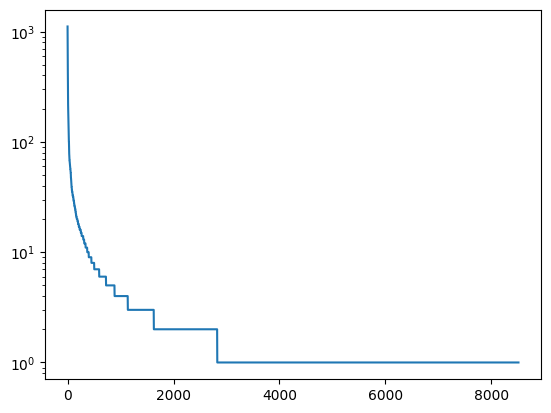

In [ ]:
# display word occurrences first
plt.figure()
plt.semilogy(-np.sort(-np.sum(Mwd_2024,axis=1)))
plt.savefig(out_dir+out_file_2024+"_statistics.png")

In [ ]:
# remove words that are used once or twice
select_2024 = (np.sum(Mwd_2024,axis=1)>2)
Mwd_2024 = Mwd_2024[select_2024,:]
words_2024 = words_2024[select_2024]
# remove documents that do not contain words
select_2024 = (np.sum(Mwd_2024,axis=0)>0)
Mwd_2024 = Mwd_2024[:,select_2024]
documents_2024 = documents_2024[select_2024]
# display final matrix size
display(Mwd_2024.shape)

In [ ]:
empty_rows = []
for i in range(len(select_2024)):
  if select_2024[i] == False:
    empty_rows.append(i)

In [ ]:
df_2024.drop(empty_rows, inplace = True)

In [ ]:
df_2024.reset_index(drop=True, inplace=True)

In [ ]:
not_wanted = np.array(Mwd_2024.sum(axis=1)).flatten()>Mwd_2024.shape[1]/4
text = "removing: " + " ".join(words_2024[not_wanted])
words = words_2024[~not_wanted]
Mwd = Mwd_2024[~not_wanted,:]

In [ ]:
wanted = np.array(Mwd.sum(axis=0)).flatten()>1

In [ ]:
wanted[622] = False

In [ ]:
rows_to_remove = []
for i in range(len(wanted)):
  if wanted[i] == False:
    rows_to_remove.append(i)

In [ ]:
df_2024.drop(rows_to_remove, inplace = True)

In [ ]:
df_2024.reset_index(drop=True, inplace=True)

In [ ]:
df_2024

,id,created,body,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags
0,kpkehh1,2024-02-09,"Ore 01:36, 4611 commenti!\n\n**Risultati della...",ore commenti risultati della terza serata ha v...,ore commenti risultati della terza serata vota...,"[ore NOUN, commenti PROPN, risultati PROPN, de...",[]
1,kpjfwdd,2024-02-08,Questo era Mr.Rain da giovane. Feel old yet?\n...,questo era mr rain da giovane feel old yet,questo era mr rain da giovane feel old yet,"[questo PROPN, era NOUN, mr PROPN, rain NOUN, ...",[]
2,kpjvbo4,2024-02-08,RUSSEL PAZZO UOMO HA NOMINATO IL QUA QUA GATE,russel pazzo uomo ha nominato il qua qua gate,russel pazzo uomo nominato il qua gate,"[russel NOUN, pazzo PROPN, uomo PROPN, nominat...",[]
3,kpj9o1y,2024-02-08,"Ah si, Mameli - il twink che sognò l’Italia",ah si mameli il twink che sogno l italia,si mameli il twink che sogno l italia,"[si PROPN, mameli PROPN, il PROPN, twink PROPN...",[]
4,kpjg6ii,2024-02-08,Per citare un saggio:\n\nhttps://preview.redd....,per citare un saggio,citare un saggio,"[citare NOUN, un PROPN, saggio PROPN]",[]
...,...,...,...,...,...,...,...
1938,kp8ngw9,2024-02-06,Annalisa is the best,annalisa is the best,annalisa good,"[annalisa NOUN, good ADJ]",[]
1939,kp8wzzs,2024-02-06,Is anyone still watching lol??,is anyone still watching lol,still watch lol,"[still ADV, watch VERB, lol NOUN]",[]
1940,kpd843u,2024-02-07,Che ci fa Chiara Ferragni a Sanremo?,che ci fa chiara ferragni a sanremo,che ci fa chiara ferragni sanremo,"[che PROPN, ci PROPN, fa PROPN, chiara PROPN, ...",[]
1941,kpgc0yx,2024-02-08,GEOLIER il più forte 🙌,geolier il piu forte,geoli il piu forte,"[geoli ADJ, il PROPN, piu PROPN, forte PROPN]",[]


In [ ]:
# store the results
out_dir = "drive/MyDrive/Network_science_project/"
out_file_2024 = "reddit_comments_2024"
df_2024.to_excel(out_dir+out_file_2024+"_cleaned.xlsx", index=True)

In [ ]:
# store the result
pickle.dump([Mwd_2024,words_2024,documents_2024], open(out_dir+out_file_2024+"_occurrences.p", "wb"))

# Loading data

In [ ]:
in_dir = "drive/MyDrive/Network_science_project/"
in_file_2024 = "reddit_comments_2024"

# load word occurrences
Mwd_2024, words_2024, documents_2024 = pickle.load(open(in_dir+in_file_2024+"_occurrences.p","rb"))
Mwd_2024 = sps.csr_matrix(Mwd_2024)

# Degree distribution

2.0121203157983514


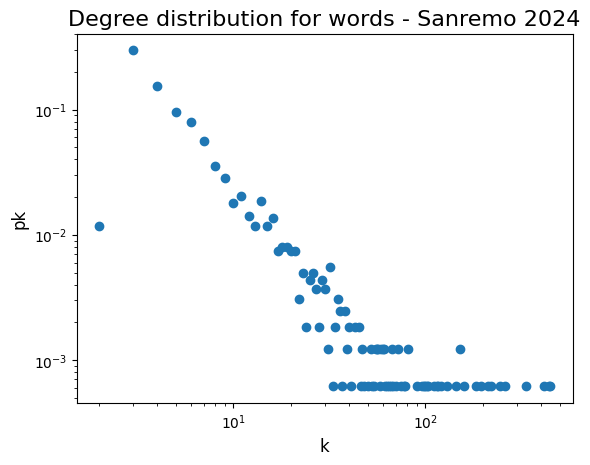

In [108]:
dw_2024 = np.squeeze(np.asarray(Mwd_2024.sum(axis=1))) # words degrees
k_2024 = np.unique(dw_2024)
pk_2024 = np.histogram(dw_2024,np.append(k_2024,k_2024[-1]+1))[0] # append is a trick to add the last degree
pk_2024 = pk_2024/pk_2024.sum() # normalization
Pk_2024 = 1-np.cumsum(pk_2024) # complementary cumulative distribution

k_min = 30

filtered_k_2024 = k_2024[k_2024 > k_min]

gamma_words_2024 = 1 + 1/np.mean(np.log(filtered_k_2024/k_min))
print(gamma_words_2024)

fig = plt.figure()
plt.loglog(k_2024,pk_2024,'o')
plt.title("Degree distribution for words - Sanremo 2024", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show() # log-log plot

2.0269243892334528


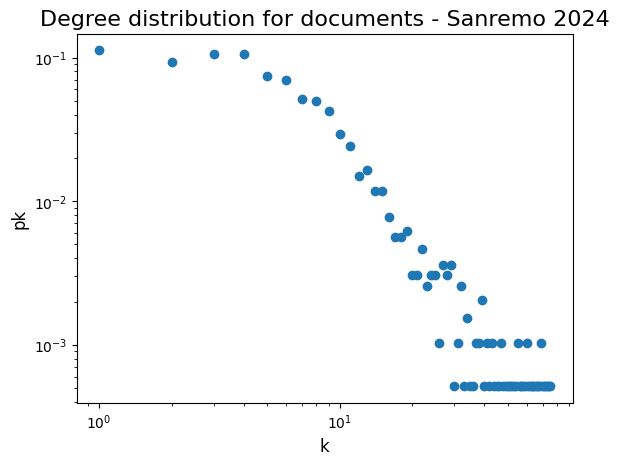

In [111]:
# degree distribution for documents
dd_2024 = np.squeeze(np.asarray(Mwd_2024.sum(axis=0))) # documents degrees
k_2024 = np.unique(dd_2024)
pk_2024 = np.histogram(dd_2024, np.append(k_2024, k_2024[-1] + 1))[0]
pk_2024 = pk_2024/pk_2024.sum()
Pk_2024 = 1-np.cumsum(pk_2024)

k_min = 22

filtered_k_2024 = k_2024[k_2024 > k_min]

gamma_words_2024 = 1 + 1/np.mean(np.log(filtered_k_2024/k_min))
print(gamma_words_2024)

fig = plt.figure()
plt.loglog(pk_2024,'o')
plt.title("Degree distribution for documents - Sanremo 2024", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

# Centrality measures



In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/NSlab2/communities_mod.ipynb"

In [ ]:
Mwd_2024, words_2024, documents_2024 = clean_Mwd_matrix(Mwd_2024, words_2024, documents_2024)
Pwd_2024, Pww_2024, Pdd_2024, Paa_2024 = probability_matrices(Mwd_2024, tform=False)

In [ ]:
A_pdd_2024 = sps.csr_matrix(Pdd_2024)
G_pdd_2024 = ig.Graph.Adjacency((A_pdd_2024 > 0).toarray().tolist())
G_pdd_2024.es['weight'] = np.array(A_pdd_2024[A_pdd_2024.nonzero()])[0]

In [ ]:
node_label = df_2024["text_deep_clean"]

In [ ]:
node_label = list(node_label)

In [ ]:
G_pdd_2024.vs["name"] = node_label

In [ ]:
list_of_edges = G_pdd_2024.get_edgelist()

In [ ]:
edge_label = []

In [ ]:
for edge in list_of_edges:
  edge_label.append(node_label[edge[0]] + " - " + node_label[edge[1]])

In [ ]:
import csv

In [ ]:
file_name = 'drive/MyDrive/Network_science_project/node_list.csv'

# Writing to the CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    for item in node_label:
        writer.writerow([item])

In [ ]:
file_name = 'drive/MyDrive/Network_science_project/edge_list.csv'

# Writing to the CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    for item in edge_label:
        writer.writerow([item])

In [ ]:
degree_centrality_2024 = G_pdd_2024.degree()
print("Degree Centrality for Sanremo documents 2024:")
print(degree_centrality_2024)

Degree Centrality for Sanremo documents 2024:
[2514, 534, 130, 358, 682, 1192, 742, 2128, 958, 218, 16, 622, 1506, 126, 586, 752, 1150, 1008, 820, 2344, 740, 18, 248, 1398, 1368, 918, 70, 314, 22, 116, 724, 224, 700, 164, 260, 156, 1224, 876, 438, 992, 452, 186, 258, 96, 358, 1096, 1038, 168, 404, 2232, 52, 1336, 352, 1690, 804, 1426, 128, 124, 646, 84, 144, 332, 1016, 1848, 446, 400, 386, 690, 894, 570, 1200, 1554, 1080, 938, 196, 660, 1504, 164, 186, 430, 382, 1676, 930, 160, 924, 584, 184, 826, 82, 260, 1286, 674, 352, 986, 728, 1246, 1798, 562, 714, 1046, 94, 2658, 560, 1212, 802, 1362, 776, 680, 1550, 296, 42, 806, 154, 1902, 40, 752, 828, 116, 614, 1986, 198, 282, 484, 762, 2318, 910, 1138, 776, 386, 1740, 1252, 448, 62, 964, 116, 1438, 812, 876, 842, 1000, 532, 884, 792, 886, 394, 446, 1260, 1210, 700, 1322, 928, 1070, 502, 12, 1112, 1128, 1478, 104, 266, 228, 1554, 978, 250, 356, 824, 1432, 222, 860, 1200, 1038, 1012, 800, 470, 1220, 12, 350, 720, 346, 1108, 226, 256, 762, 1720

In [ ]:
indexed_values_dc = list(enumerate(degree_centrality_2024))
sorted_by_value_dc = sorted(indexed_values_dc, key=lambda x: x[1], reverse=True)
indices_of_top_10_dc = [index for index, value in sorted_by_value_dc[:10]]

In [56]:
for i in range(10):
  print(G_pdd_2024.vs[indices_of_top_10_dc[i]]["name"] + "\n")

verita e quello che non dice nessuno e che l agricoltura di essere trasformata perche il mondo un agricoltura ma non di questa una agricoltura moderna efficente scientifica e giovane e deve essere fatto livello europeo deve cambiare la mentalita di agricoltura come orticello di casa ettari la medium italiana contro francesi e ucraina appezzamenti da oltre perche non puoi fare un attivita imprenditoriale nel come anni fa con ettari senza consonziarsi e quindi avendo meno potere quando entri nel mercato protestano poi cosa hanno il del bilancio europeo un settore che rappresenta appena il italia hanno pure l esenzione da anni dell irpef dai redditi domenicali e agrari gli imprenditori agricoli anni e questa e uno dei motivi delle proteste non ci avete fatto pagare l irpef anni adesso volete che lo paghiamo si cazzo devo pagare solo io tasse mi sembra una misura di equita non esiste un paese che pratica il rispetto degli obblighi tributari distinguendo da come lo percepisci che invece noi

In [ ]:
betweenness_centrality_2024 = G_pdd_2024.betweenness()
print("Betweenness Centrality for Sanremo documents 2024:")
print(betweenness_centrality_2024)

Betweenness Centrality for Sanremo documents 2024:
[25505.133018980774, 315.87308953854557, 36.57690975004034, 488.15907994028123, 0.596586050513905, 793.4065322751399, 833.3269291223154, 8584.998757949816, 1320.604536657973, 2.416872010791868, 0.03751187084520417, 399.9258670551237, 2422.462944222511, 77.89477676050906, 1818.6988736717772, 910.9540218032804, 1195.3285168540142, 2300.180981667893, 1466.9536145322995, 12006.98527529494, 351.9427334856857, 0.0, 253.19462515183844, 2881.129630237228, 3421.3061423902705, 927.7645058933097, 14.811723113314914, 161.34048483984157, 0.6801058693084027, 258.87637830710685, 541.0102389739368, 102.70330089933488, 633.9633784961236, 152.65214570624408, 326.6493690469976, 46.668789021351785, 2255.359386609927, 1185.9787057684218, 4.625214366996401, 1171.8749587283796, 57.95982411391259, 25.11155176436054, 336.3369895011844, 10.089665108750228, 708.7372846778375, 1029.0268171744813, 5852.998383109609, 60.41223872725244, 908.1225708125182, 15054.6081

In [ ]:
indexed_values_bc = list(enumerate(betweenness_centrality_2024))
sorted_by_value_bc = sorted(indexed_values_bc, key=lambda x: x[1], reverse=True)
indices_of_top_10_bc = [index for index, value in sorted_by_value_bc[:10]]

In [58]:
for i in range(10):
  print(G_pdd_2024.vs[indices_of_top_10_bc[i]]["name"] + "\n")

verita e quello che non dice nessuno e che l agricoltura di essere trasformata perche il mondo un agricoltura ma non di questa una agricoltura moderna efficente scientifica e giovane e deve essere fatto livello europeo deve cambiare la mentalita di agricoltura come orticello di casa ettari la medium italiana contro francesi e ucraina appezzamenti da oltre perche non puoi fare un attivita imprenditoriale nel come anni fa con ettari senza consonziarsi e quindi avendo meno potere quando entri nel mercato protestano poi cosa hanno il del bilancio europeo un settore che rappresenta appena il italia hanno pure l esenzione da anni dell irpef dai redditi domenicali e agrari gli imprenditori agricoli anni e questa e uno dei motivi delle proteste non ci avete fatto pagare l irpef anni adesso volete che lo paghiamo si cazzo devo pagare solo io tasse mi sembra una misura di equita non esiste un paese che pratica il rispetto degli obblighi tributari distinguendo da come lo percepisci che invece noi

In [ ]:
closeness_centrality_2024 = G_pdd_2024.closeness()
print("Closeness Centrality for Sanremo documents 2024:")
print(closeness_centrality_2024)

Closeness Centrality for Sanremo documents 2024:
[0.7386839102320274, 0.5345444536195981, 0.49604086845466155, 0.5209227467811158, 0.5462728551336147, 0.5895567698846388, 0.5518613242398409, 0.6881644223954642, 0.5690008789920891, 0.5097112860892389, 0.4307897071872227, 0.5418526785714286, 0.6194577352472089, 0.4980764298538087, 0.5392946403776728, 0.5521751492749503, 0.5859987929993965, 0.5733687629170358, 0.5575653172552397, 0.7152854511970534, 0.5510783200908059, 0.4486024486024486, 0.5107837980010521, 0.6087774294670847, 0.6061173533083646, 0.5653566229985444, 0.48224484728085426, 0.517590618336887, 0.4329988851727982, 0.49629440327114743, 0.5493635077793494, 0.5086432687270822, 0.5478138222849083, 0.5032391811350091, 0.5062565172054223, 0.5024579560155239, 0.5926151968263655, 0.5620839363241679, 0.5275740287965227, 0.5723548482169172, 0.5281479466956758, 0.5066527524132534, 0.5132135306553911, 0.49756597489110943, 0.5214822771213748, 0.581263094881772, 0.5759193357058126, 0.504808

In [ ]:
indexed_values_cc = list(enumerate(closeness_centrality_2024))
sorted_by_value_cc = sorted(indexed_values_cc, key=lambda x: x[1], reverse=True)
indices_of_top_10_cc = [index for index, value in sorted_by_value_cc[:10]]

In [59]:
for i in range(10):
  print(G_pdd_2024.vs[indices_of_top_10_cc[i]]["name"] + "\n")

verita e quello che non dice nessuno e che l agricoltura di essere trasformata perche il mondo un agricoltura ma non di questa una agricoltura moderna efficente scientifica e giovane e deve essere fatto livello europeo deve cambiare la mentalita di agricoltura come orticello di casa ettari la medium italiana contro francesi e ucraina appezzamenti da oltre perche non puoi fare un attivita imprenditoriale nel come anni fa con ettari senza consonziarsi e quindi avendo meno potere quando entri nel mercato protestano poi cosa hanno il del bilancio europeo un settore che rappresenta appena il italia hanno pure l esenzione da anni dell irpef dai redditi domenicali e agrari gli imprenditori agricoli anni e questa e uno dei motivi delle proteste non ci avete fatto pagare l irpef anni adesso volete che lo paghiamo si cazzo devo pagare solo io tasse mi sembra una misura di equita non esiste un paese che pratica il rispetto degli obblighi tributari distinguendo da come lo percepisci che invece noi

In [ ]:
pagerank_2024 = G_pdd_2024.pagerank()
print("PageRank for Sanremo documents 2024:")
print(pagerank_2024)

PageRank for Sanremo documents 2024:
[0.0015625305866681287, 0.0003759912068561089, 0.00015567303883221796, 0.00029648950888391356, 0.00042684734118056243, 0.0007012204182622114, 0.0004924152474070626, 0.0012596139283075703, 0.0006022807718272647, 0.00019774527273598943, 9.50372073822718e-05, 0.0004199340266223865, 0.0008814305842096678, 0.00016718143575271277, 0.0004200406002870685, 0.0004903174180956885, 0.0006911683928525388, 0.0006384959647854204, 0.0005499391175513912, 0.001394026889465027, 0.0004728762696016826, 9.941641574192691e-05, 0.00022984787179353017, 0.0008493669433316232, 0.0008368445440499608, 0.0005700241248552678, 0.00012998806657719335, 0.00026067059566832294, 0.0001022572508506466, 0.0001838665672332298, 0.0004722357442244266, 0.00021153414200812603, 0.0004535271365946067, 0.0001860738637788534, 0.0002478163025515236, 0.00016911565316067765, 0.0007528439768617612, 0.0005633835471588607, 0.00030635856311970566, 0.0006196294862981967, 0.00031861313402333055, 0.0001796

In [ ]:
indexed_values_pr = list(enumerate(pagerank_2024))
sorted_by_value_pr = sorted(indexed_values_pr, key=lambda x: x[1], reverse=True)
indices_of_top_10_pr = [index for index, value in sorted_by_value_pr[:10]]

In [60]:
for i in range(10):
  print(G_pdd_2024.vs[indices_of_top_10_pr[i]]["name"] + "\n")

verita e quello che non dice nessuno e che l agricoltura di essere trasformata perche il mondo un agricoltura ma non di questa una agricoltura moderna efficente scientifica e giovane e deve essere fatto livello europeo deve cambiare la mentalita di agricoltura come orticello di casa ettari la medium italiana contro francesi e ucraina appezzamenti da oltre perche non puoi fare un attivita imprenditoriale nel come anni fa con ettari senza consonziarsi e quindi avendo meno potere quando entri nel mercato protestano poi cosa hanno il del bilancio europeo un settore che rappresenta appena il italia hanno pure l esenzione da anni dell irpef dai redditi domenicali e agrari gli imprenditori agricoli anni e questa e uno dei motivi delle proteste non ci avete fatto pagare l irpef anni adesso volete che lo paghiamo si cazzo devo pagare solo io tasse mi sembra una misura di equita non esiste un paese che pratica il rispetto degli obblighi tributari distinguendo da come lo percepisci che invece noi

# Community detection

In [62]:
# Building a feature matrix based on PageRank
feature_matrix_2024 = np.array(pagerank_2024).reshape(-1, 1)

In [63]:
# Scaling the feature matrix
scaler = StandardScaler()
features_matrix_2024_scaled = scaler.fit_transform(feature_matrix_2024)

cluster_size_list_2024 = []
# Apply HDBSCAN
for i in range(2, 150):
  clusterer_2024 = HDBSCAN(min_cluster_size=i)
  clusters_2024 = clusterer_2024.fit_predict(features_matrix_2024_scaled)
  cluster_size_list_2024.append(len(set(clusters_2024)))

In [64]:
# Keeping only the clusters with 40 or less communities

filtered_list_indeces_2024 = [index for index, element in enumerate(cluster_size_list_2024) if element <= 40]
filtered_list_2024 = [element for index, element in enumerate(cluster_size_list_2024) if element <= 40]

cluster_2024_list = []
for element in filtered_list_indeces_2024:
  clusterer_2024 = HDBSCAN(min_cluster_size=element+2)
  clusters_2024 = clusterer_2024.fit_predict(features_matrix_2024_scaled)
  cluster_2024_list.append(clusters_2024)

In [65]:
# Creating dictionaries with the community assignment

community_dicts_2024 = [defaultdict(list) for _ in range(len(cluster_2024_list))]

for i in range(len(cluster_2024_list)):
  for index, community in enumerate(cluster_2024_list[i]):
    community_dicts_2024[i][community].append(index)

for i in range(len(cluster_2024_list)):
  community_dicts_2024[i] = dict(community_dicts_2024[i])

In [66]:
# Storing the communities in sparse matrices

matrix_dimensions_2024 = []
for i in range(len(cluster_2024_list)):
  matrix_dimensions_2024.append((Pdd_2024.shape[0], filtered_list_2024[i]))

sparse_matrices_2024 = [csr_matrix(dimensions) for dimensions in matrix_dimensions_2024]

for j in range(len(filtered_list_2024)):
  for i in list(range(-1, filtered_list_2024[j]-1)):
    sparse_matrices_2024[j][np.array(community_dicts_2024[j][i]), i] = 1

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [67]:
df_2024 = pd.DataFrame(data={'data':[], 'c#':[],
                        'NMI':[], 'Q':[], 'Ncut':[], 'InfoMap':[]})

# identify the infomap ranking vector

r_2024 = infomap_rank(Pdd_2024)

In [68]:
stats_matrix_2024 = np.empty((len(filtered_list_2024), 4))

for i in range(len(filtered_list_2024)):
  stats_matrix_2024[i] = clustering_statistics(sparse_matrices_2024[i], Pwd_2024, Pdd_2024, r_2024)
  df_2024.loc[len(df_2024)] = [in_file_2024, sparse_matrices_2024[i].shape[1], stats_matrix_2024[i][0], stats_matrix_2024[i][1], stats_matrix_2024[i][2], stats_matrix_2024[i][3]]


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Cha

In [69]:
display(df_2024)
# store the result
df_2024.to_csv("drive/MyDrive/Network_science_project/hdbscan_2024.csv")

,data,c#,NMI,Q,Ncut,InfoMap
0,reddit_comments_2024,39,0.372512,0.136214,0.825676,0.091399
1,reddit_comments_2024,36,0.368780,0.135750,0.821205,0.090041
2,reddit_comments_2024,21,0.275344,0.123731,0.858200,0.085650
3,reddit_comments_2024,20,0.276466,0.125122,0.853695,0.084755
4,reddit_comments_2024,6,0.176973,0.039781,0.769244,0.047657
...,...,...,...,...,...,...
133,reddit_comments_2024,3,0.215215,0.134136,0.535017,0.068131
134,reddit_comments_2024,3,0.214759,0.133890,0.534999,0.068268
135,reddit_comments_2024,3,0.213705,0.133493,0.535570,0.068346
136,reddit_comments_2024,3,0.214815,0.134222,0.534731,0.068179


In [70]:
# Scaling the metrics
scaler = MinMaxScaler()
scaler.fit(stats_matrix_2024)
std_metrics_2024 = scaler.transform(stats_matrix_2024)
# Choosing the best community assignment according to a composite metric
# where Modularity has an higher weight
np.argmax(std_metrics_2024[:,0]*0.2 + std_metrics_2024[:,1]*0.4 - std_metrics_2024[:,2]*0.2 - std_metrics_2024[:,3]*0.2)

107

In [71]:
# Best community assignment according to modularity
np.argmax(std_metrics_2024[:,1])

46

In [72]:
C_hdb_mod = sparse_matrices_2024[44]

In [73]:
C_hdb = sparse_matrices_2024[105]

In [74]:
in_dir = "drive/MyDrive/Network_science_project/"
in_file_2024 = "reddit_comments_2024"

In [75]:
display(pd.read_excel(in_dir + in_file_2024 + "_cleaned.xlsx"))

,Unnamed: 0,id,created,body,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags
0,0,kpkehh1,2024-02-09,"Ore 01:36, 4611 commenti!\n\n**Risultati della...",ore commenti risultati della terza serata ha v...,ore commenti risultati della terza serata vota...,"['ore NOUN', 'commenti PROPN', 'risultati PROP...",[]
1,1,kpjfwdd,2024-02-08,Questo era Mr.Rain da giovane. Feel old yet?\n...,questo era mr rain da giovane feel old yet,questo era mr rain da giovane feel old yet,"['questo PROPN', 'era NOUN', 'mr PROPN', 'rain...",[]
2,2,kpjvbo4,2024-02-08,RUSSEL PAZZO UOMO HA NOMINATO IL QUA QUA GATE,russel pazzo uomo ha nominato il qua qua gate,russel pazzo uomo nominato il qua gate,"['russel NOUN', 'pazzo PROPN', 'uomo PROPN', '...",[]
3,3,kpj9o1y,2024-02-08,"Ah si, Mameli - il twink che sognò l’Italia",ah si mameli il twink che sogno l italia,si mameli il twink che sogno l italia,"['si PROPN', 'mameli PROPN', 'il PROPN', 'twin...",[]
4,4,kpjg6ii,2024-02-08,Per citare un saggio:\n\nhttps://preview.redd....,per citare un saggio,citare un saggio,"['citare NOUN', 'un PROPN', 'saggio PROPN']",[]
...,...,...,...,...,...,...,...,...
1938,1938,kp8ngw9,2024-02-06,Annalisa is the best,annalisa is the best,annalisa good,"['annalisa NOUN', 'good ADJ']",[]
1939,1939,kp8wzzs,2024-02-06,Is anyone still watching lol??,is anyone still watching lol,still watch lol,"['still ADV', 'watch VERB', 'lol NOUN']",[]
1940,1940,kpd843u,2024-02-07,Che ci fa Chiara Ferragni a Sanremo?,che ci fa chiara ferragni a sanremo,che ci fa chiara ferragni sanremo,"['che PROPN', 'ci PROPN', 'fa PROPN', 'chiara ...",[]
1941,1941,kpgc0yx,2024-02-08,GEOLIER il più forte 🙌,geolier il piu forte,geoli il piu forte,"['geoli ADJ', 'il PROPN', 'piu PROPN', 'forte ...",[]


In [93]:
df2 = pd.read_excel(in_dir + in_file_2024 + "_cleaned.xlsx")
df2["id"] = np.array([str(i) for i in df2["id"]])

documents = np.array([str(i) for i in documents_2024])
#df2 = df2.loc[df2['id'].isin(documents)]
df2.index = np.array(range(len(df2)))

df2["text_deep_clean2"] = [str(df2["text_deep_clean"][i]) + " #" +
                           df2["hashtags"][i][2:-2].replace("', '"," #")
                           for i in range(len(df2))]

In [77]:
# Louvain

tic = time.time()

A = sps.csr_matrix(Pdd_2024)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

part_2024 = louvain.find_partition(G, louvain.ModularityVertexPartition,
                                 weights = 'weight')


def partition_to_C(part):
  C = sps.csr_matrix((Pdd_2024.shape[0], len(part)))
  for i in range(len(part)):
    C[np.array(part[i]), i] = 1
  return C

C_l = partition_to_C(part_2024)

et_louv = time.time() - tic

C_sl, _, _ = my_soft_louvain(Pdd_2024, C_l)

et_slouv = time.time()-tic

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[1943, 1943]
195.1614716074875
59.39696961966995
22.62741699796953
9.899494936611667
2.8284271247461903
1.4142135623730951
0.0
[1943, 32]
4.242640687119286
0.0
[1943, 31]
0.0


In [95]:
# BERTopic

tic = time.time()

bert_model = BERTopic()

docs = list(df2["body"])
topics, probabilities = bert_model.fit_transform(docs)


def topics_to_C(topics):
  C = sps.csr_matrix((len(topics),max(topics)+2))
  for i in range(C.shape[1]):
    C[np.array(topics)==(i-1),i] = 1
  C = C[:,np.unique(scipy.sparse.find(C)[1])]
  return C

C_b = topics_to_C(topics)

et_bert = time.time()-tic

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [96]:
df_communities_2024 = pd.DataFrame(data={'data':[], 'algo':[], 'time':[], 'c#':[],
                        'NMI':[], 'Q':[], 'Ncut':[], 'InfoMap':[]})

In [97]:
# hard Louvain
stats_2024 = clustering_statistics(C_l, Pwd_2024, Pdd_2024, r_2024)
df_communities_2024.loc[len(df_communities_2024)] = [in_file_2024, "hard Louvain Pdd", et_louv, C_l.shape[1]] + stats_2024

# soft Louvain
stats_2024 = clustering_statistics(C_sl, Pwd_2024, Pdd_2024, r_2024)
df_communities_2024.loc[len(df_communities_2024)] = [in_file_2024, "soft Louvain Pdd", et_slouv, C_sl.shape[1]] + stats_2024

# BERTopic
stats_2024 = clustering_statistics(C_b, Pwd_2024, Pdd_2024, r_2024)
df_communities_2024.loc[len(df_communities_2024)] = [in_file_2024, "BERTopic", et_bert, C_b.shape[1]] + stats_2024


# HDBSCAN
stats_2024 = clustering_statistics(C_hdb, Pwd_2024, Pdd_2024, r_2024)
df_communities_2024.loc[len(df_communities_2024)] = [in_file_2024, "HDBSCAN", "", C_hdb.shape[1]] + stats_2024


# HDBSCAN Mod
stats_2024 = clustering_statistics(C_hdb_mod, Pwd_2024, Pdd_2024, r_2024)
df_communities_2024.loc[len(df_communities_2024)] = [in_file_2024, "HDBSCAN Mod", "", C_hdb_mod.shape[1]] + stats_2024

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [98]:
display(df_communities_2024)

,data,algo,time,c#,NMI,Q,Ncut,InfoMap
0,reddit_comments_2024,hard Louvain Pdd,7.838102,32,0.481053,0.320362,0.633845,0.012399
1,reddit_comments_2024,soft Louvain Pdd,24.156291,31,0.480640,0.321070,0.630844,0.012660
2,reddit_comments_2024,BERTopic,65.515777,34,0.405393,0.161195,0.760728,0.055721
3,reddit_comments_2024,HDBSCAN,,4,0.254881,0.135648,0.596759,0.068682
4,reddit_comments_2024,HDBSCAN Mod,,8,0.275352,0.141757,0.742223,0.076889


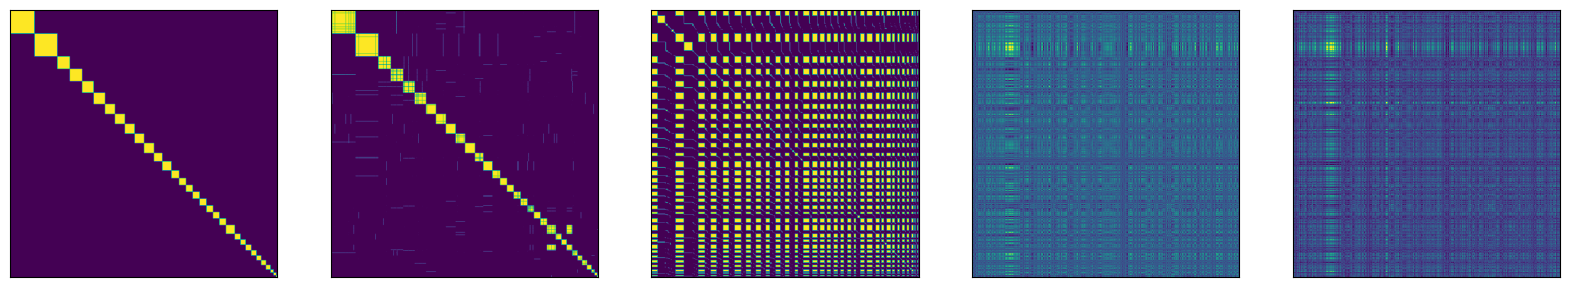

In [99]:
plot_community_patterns([C_l, C_sl, C_b, C_hdb, C_hdb_mod], nrows=1, ncols=5, refs=[0, 2])

Text(0.5, 1.0, 'HDBSCAN Mod')

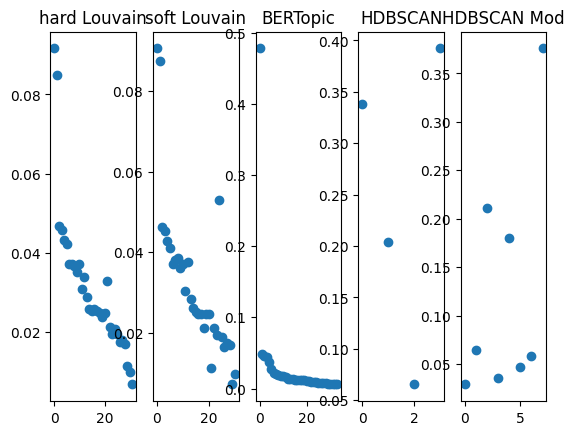

In [100]:
# show number of documents per community
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.plot(np.array(C_l.sum(axis=0))[0]/C_l.sum(),'o')
ax1.set_title('hard Louvain')
ax2.plot(np.array(C_sl.sum(axis=0))[0]/C_sl.sum(),'o')
ax2.set_title('soft Louvain')
ax3.plot(np.array(C_b.sum(axis=0))[0]/C_b.sum(),'o')
ax3.set_title('BERTopic')
ax4.plot(np.array(C_hdb.sum(axis=0))[0]/C_hdb.sum(),'o')
ax4.set_title('HDBSCAN')
ax5.plot(np.array(C_hdb_mod.sum(axis=0))[0]/C_hdb_mod.sum(),'o')
ax5.set_title('HDBSCAN Mod')

In [101]:
# Louvain

docs = list(df2["text_deep_clean2"])
bert_model1 = bertopic_overwrite(bert_model,docs,C_l)

bert_model1.visualize_barchart(topics = range(C_l.shape[1]),
                               n_words = 8,
                               title = "Louvain results")

In [102]:
# BERTopic

docs = list(df2["text_deep_clean"])
bert_model2 = bertopic_overwrite(bert_model,docs,C_b)

bert_model2.visualize_barchart(topics = range(C_b.shape[1]),
                               n_words = 8,
                               title = "BERTopic results")

In [103]:
# HDBSCAN

docs = list(df2["text_deep_clean"])
bert_model3 = bertopic_overwrite(bert_model,docs,C_hdb)

bert_model3.visualize_barchart(topics = range(C_hdb.shape[1]),
                               n_words = 8,
                               title = "HDBSCAN results")

In [104]:
# HDBSCAN Mod

docs = list(df2["text_deep_clean"])
bert_model3 = bertopic_overwrite(bert_model,docs,C_hdb_mod)

bert_model3.visualize_barchart(topics = range(C_hdb_mod.shape[1]),
                               n_words = 8,
                               title = "HDBSCAN Mod results")